This note is all about univarient Time series prediction Using Tensorflow  framework and  LSTM ..Please upvote!

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random

In [2]:
# go to input dir of stocks and use one txt file for processing

os.chdir('../input/price-volume-data-for-all-us-stocks-etfs/Stocks')

In [3]:
files=os.listdir()
len(files)

7195

In [4]:

data=random.sample([x for x in files if x.endswith('txt') and x.startswith('cms')and os.path.getsize(x)>400000],1)

In [5]:
data

['cms.us.txt']

#data will be of type list , so we need to iterate thrpugh elements of data to read file

In [6]:
for i in data:
    df = pd.read_csv(i)


In [7]:
#set date column as index and drop from dataframe
df=df.set_index(df['Date'])
df.drop('Date',axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-12-31,2.1121,2.2303,2.1121,2.2303,1003711,0
1985-01-02,2.2303,2.2303,2.1750,2.2303,126257,0
1985-01-03,2.2303,2.2303,2.1750,2.2303,62047,0
1985-01-04,2.2303,2.2303,2.1750,2.2303,76517,0
1985-01-07,2.1750,2.2303,2.1750,2.1750,96819,0


In [8]:
df.shape

(8280, 6)

For timeseries prediction we need window size on which output will depend example if today's forecast depends on last ten days then window size will be 10

In [9]:
window_size=30
train_data=df.iloc[:(7200+window_size), 0:1]
train_data.shape

(7230, 1)

In [10]:
#preprocess data using Minmax sclaer
scaler=preprocessing.MinMaxScaler()
train_data_transform=scaler.fit_transform(np.array(train_data))

In [11]:
x_train,y_train=[],[]
for i in range(len(train_data_transform)-window_size):
    x_train.append(train_data_transform[i:i+window_size])
    y_train.append(train_data_transform[i+window_size])
    

In [12]:
x_train=np.array(x_train)

In [13]:
y_train=np.array(y_train)
y_train.shape

(7200, 1)

#LSTM require data to be in 3d shape (samples,window_size,features)

In [14]:
model=tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.LSTM(50,return_sequences=True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(50),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1)
    ])


model.summary()
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [15]:
model.fit(x_train, y_train, epochs=13, batch_size=40)

Epoch 1/13
180/180 [==============================] - 12s 45ms/step - loss: 0.0167 - accuracy: 1.8516e-04
Epoch 2/13
180/180 [==============================] - 8s 44ms/step - loss: 0.0022 - accuracy: 2.4050e-05
Epoch 3/13
180/180 [==============================] - 8s 45ms/step - loss: 0.0018 - accuracy: 2.2932e-04
Epoch 4/13
180/180 [==============================] - 8s 46ms/step - loss: 0.0018 - accuracy: 1.0237e-04
Epoch 5/13
180/180 [==============================] - 8s 45ms/step - loss: 0.0016 - accuracy: 2.0718e-04
Epoch 6/13
180/180 [==============================] - 8s 44ms/step - loss: 0.0013 - accuracy: 3.9359e-05
Epoch 7/13
180/180 [==============================] - 8s 45ms/step - loss: 0.0012 - accuracy: 2.1063e-04
Epoch 8/13
180/180 [==============================] - 8s 47ms/step - loss: 0.0012 - accuracy: 3.3982e-04
Epoch 9/13
180/180 [==============================] - 8s 45ms/step - loss: 0.0010 - accuracy: 2.7107e-04
Epoch 10/13
180/180 [==============================] -

For predicting values for test data twe would need train input of  length =window size, so that we will able to predict first value of test data

In [16]:
train_data = df.iloc[ :int(7200)]
test_data = df.iloc[int(7200): ]
        
        # combining the dataset and taking final test_data shape.
data = pd.concat((train_data['Open'], test_data['Open']), axis=0)
        # len(train_data) - window_size == 7242 - 10 == 7432.
        # Hence, test_set starts from 7432 to take 7243 row as output.
test_input_shape = data[len(train_data) - window_size: ].values
test_input_shape = test_input_shape.reshape(-1,1)
test_input_shape = scaler.transform(test_input_shape) #only transforming the test data.
        
X_test = []
        
for i in range(window_size, len(test_data)+window_size): 
    X_test.append(test_input_shape[i-window_size:i, 0])
            
X_test = np.array(X_test)

In [17]:
X_test.shape

(1080, 30)

In [18]:
 #to make values compatible with lstm
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
prediction = model.predict(X_test)

prediction_inverse = scaler.inverse_transform(prediction)

In [20]:
prediction_inverse.shape

(1080, 1)

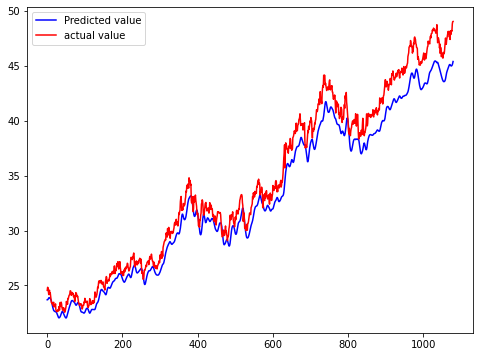

In [21]:

y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(8,6))
plt.plot(prediction_inverse, color='blue', label='Predicted value')
plt.plot(y_test, color ='red', label='actual value')
plt.legend()
plt.show()



In [22]:

print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction_inverse))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction_inverse))

Mean Absolute Error:  1.461167128697148
Mean Squared Error:  2.843034630400604
